In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_compressed_sensing import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_sensor_per_node'] = 13
problem_spec['n_node'] = 6
problem_spec['n_sensor'] = problem_spec['n_sensor_per_node'] * problem_spec['n_node']
problem_spec['vector_size'] = 100
problem_spec['n_nonzero_entry'] = int(np.ceil(0.2 * problem_spec['vector_size']))
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_data['rho'] = 0.01

# PG-EXTRA hyperparameters
problem_data['alpha'] = 2.5
problem_data['itr_num'] = 1000

{'n_sensor_per_node': 13, 'n_node': 6, 'n_sensor': 78, 'vector_size': 100, 'n_nonzero_entry': 20}


In [3]:
lmbd_min = np.linalg.eigvalsh(network_data['W']).min()
print(f"lambda_min(W) = {lmbd_min}")
n_sensor_per_node = problem_spec['n_sensor_per_node']
lmbds = []
for jj in range(problem_spec['n_node']) :
    A_temp = problem_data['A'][jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    lmbds += [np.linalg.eigvalsh(A_temp.T @ A_temp).max()]
print(f"L_max = {max(lmbds)}")
print(f"{(1 + lmbd_min) / max(lmbds)=}")

lambda_min(W) = -0.0822580400531801
L_max = 0.14239495013689374
(1 + lmbd_min) / max(lmbds)=6.4450456920314485


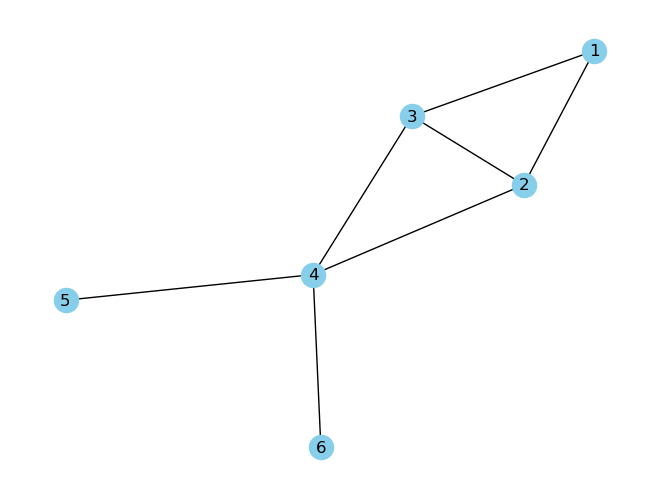

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
# plt.savefig("plots/graph_n6.pdf")

In [5]:
# obtain true solution to L1-regularized optimization problem
x_opt_star, f_star = obtain_opt_prob_solution(problem_spec, problem_data, network_data)

In [6]:
f_cvx, x_cvx = cvx_compressed_sensing(problem_spec, problem_data)
print(f_star, f_cvx)
f_star, x_opt_star = f_cvx, x_cvx
print(f"{f_star=}, {np.linalg.norm(x_cvx)=}")

0.48149727611721793 0.481497276117218
f_star=0.481497276117218, np.linalg.norm(x_cvx)=2.6729841275541717


In [7]:
# assert np.allclose(f_cvx, f_star) and np.linalg.norm(x_cvx - x_opt_star, ord='fro') < 1e-8, print(f_cvx, f_star)

In [8]:
# params={"R":18, "Inductance":10, "Capacitance":5, "h":1.1069481843901916}
# dadmm_l_err_opt_star, dadmm_l_err_opt_reldiff, dadmm_l_const_vio, dadmm_l_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operator=cvx_prox_fj_hj,
#                                                                                 params=params, printing=True)

In [9]:
rho = problem_data['rho']
A = problem_data['A']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_sensor = problem_spec['n_sensor']
n_sensor_per_node = problem_spec['n_sensor_per_node']
n_node = problem_spec['n_node']

prox_operators = []
fi_operators = []
b_stack = np.reshape(np.repeat(b, n_node), (n_sensor, n_node))
for jj in range(n_node):
    Aj = A[jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    bj = b[jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    prox_operators += [lambda z, alpha, Aj=Aj, bj=bj:  cvx_prox_fj_hj(z, alpha, rho, Aj, bj, vector_size)]
    fi_operators += [lambda x_kj, Aj=Aj, bj=bj: 1/2*np.sum((Aj @ x_kj - bj)**2) + rho * np.sum(np.abs(x_kj))]

In [10]:
R = 10
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True)

ii=0, f_reldiff[-1]=0.04312681633959755, err_opt_reldiff[-1]=0.9657159665926579
ii=50, f_reldiff[-1]=0.0017896373399219022, err_opt_reldiff[-1]=0.19424800876007095
ii=100, f_reldiff[-1]=0.00015355350771026314, err_opt_reldiff[-1]=0.058183408354625925
ii=150, f_reldiff[-1]=1.7711020869695593e-05, err_opt_reldiff[-1]=0.018468234495144297
ii=200, f_reldiff[-1]=6.675446015410815e-06, err_opt_reldiff[-1]=0.005937883392523494
ii=250, f_reldiff[-1]=4.325266928510393e-06, err_opt_reldiff[-1]=0.0019170353121031214
ii=300, f_reldiff[-1]=1.0177670369021692e-06, err_opt_reldiff[-1]=0.0006193602897856759
ii=350, f_reldiff[-1]=8.56269667653653e-08, err_opt_reldiff[-1]=0.00020017991079947396
ii=400, f_reldiff[-1]=3.5092967297599105e-08, err_opt_reldiff[-1]=6.47313667265754e-05
ii=450, f_reldiff[-1]=3.583673435039016e-09, err_opt_reldiff[-1]=2.0943827625999667e-05
ii=500, f_reldiff[-1]=1.4077829796854455e-09, err_opt_reldiff[-1]=6.7722099115073424e-06
ii=550, f_reldiff[-1]=1.5995241922513705e-09, err_

In [11]:
params={"R":18, "Inductance":10, "h":1.1054814693822324}
ciradmm_err_opt_star, ciradmm_err_opt_reldiff, ciradmm_const_vio, ciradmm_f_reldiff = co.dadmm("cir_dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True)

ii=0, f_reldiff[-1]=0.09014586100071627, err_opt_reldiff[-1]=0.96488904706484
ii=50, f_reldiff[-1]=0.00025934149547060195, err_opt_reldiff[-1]=0.07485966017834707
ii=100, f_reldiff[-1]=9.18714142858103e-06, err_opt_reldiff[-1]=0.00965979411360191
ii=150, f_reldiff[-1]=2.840109256996793e-06, err_opt_reldiff[-1]=0.0012811524944917202
ii=200, f_reldiff[-1]=2.3282506815751837e-08, err_opt_reldiff[-1]=0.0001699898758425941
ii=250, f_reldiff[-1]=2.9390339493812626e-09, err_opt_reldiff[-1]=2.2501706656752062e-05
ii=300, f_reldiff[-1]=2.57254425820506e-10, err_opt_reldiff[-1]=2.9582785203029114e-06
ii=350, f_reldiff[-1]=3.2699342775168836e-10, err_opt_reldiff[-1]=3.7238907429483003e-07
ii=400, f_reldiff[-1]=4.411172759974904e-12, err_opt_reldiff[-1]=4.9035373877972406e-08
ii=450, f_reldiff[-1]=6.577215147053689e-13, err_opt_reldiff[-1]=6.531430092548003e-09
ii=500, f_reldiff[-1]=9.07321353327126e-14, err_opt_reldiff[-1]=8.705126930678415e-10
ii=550, f_reldiff[-1]=1.2220592560695726e-14, err_op

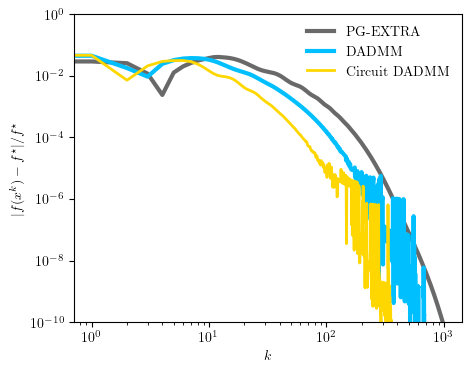

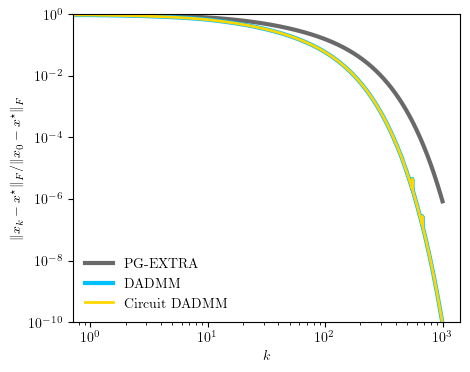

In [12]:
# apply PG-EXTRA 
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = pg_extra_compressed_sensing(None, problem_spec, problem_data, network_data, x_cvx, f_star,)

fname = "n6_circuit_dadmm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='PG-EXTRA', color=black, linewidth=3)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=3)
plt.plot(ciradmm_f_reldiff, label='Circuit DADMM',  color=green, linewidth=2)
# plt.plot(dadmm_l_f_reldiff, label='Circuit DADMM + L',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/f^\star$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-10, 1e0)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)

plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_err_opt_reldiff, label='PG-EXTRA', color=black, linewidth=3)
plt.plot(admm_err_opt_reldiff, label='DADMM', color=blue, linewidth=3)
plt.plot(admm_err_opt_reldiff, label='Circuit DADMM', color=green, linewidth=2)
# plt.plot(dadmm_l_err_opt_reldiff, label='Circuit DADMM + L', color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$\|x_k - x^\star\|_F /\|x_0 - x^\star\|_F $")
plt.ylim(1e-10, 1e0)
plt.legend()
plt.savefig(f'plots/xreldif_{fname}.pdf', dpi=300)